# Consumption Data with Principal Components

In [126]:
import pandas as pd
import numpy as np
import os
import shutil
import pickle as pk
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from keras import models
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

In [127]:
df = pd.read_csv('consumption.csv').dropna()
df.drop("Unnamed: 0", axis=1, inplace=True)

print()
print('Shape of dataframe:')
print(str(df.shape))
print()
print('Head of dataframe:')
df.head()


Shape of dataframe:
(17460, 5)

Head of dataframe:


,PC1,PC2,PC3,PC4,AnomalyType
0,-1.975673,-0.431560,0.983825,-0.502969,0
1,-1.927490,-0.413252,1.010678,-0.509047,0
2,-1.964323,-0.327661,0.940654,-0.553895,0
3,-1.887322,-0.295544,0.962395,-0.581791,0
4,-1.869729,-0.256921,0.959676,-0.597040,0


In [87]:
x = df.drop('AnomalyType', axis=1)
y = df['AnomalyType']

In [88]:
encoder = OneHotEncoder()

encoded_Y = encoder.fit(y.values.reshape(-1,1))
encoded_Y = encoded_Y.transform(y.values.reshape(-1,1)).toarray()

encoded_Y

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]])

In [89]:
train_ratio = 0.70
validation_ratio = 0.15
test_ratio = 0.15

# Generate TrainX and TrainY
trainX, testX, trainY, testY = train_test_split(x, encoded_Y, test_size= 1 - train_ratio)
# Genearate ValX, TestX, ValY and TestY
valX, testX, valY, testY = train_test_split(testX, testY, test_size=test_ratio/(test_ratio + validation_ratio))

In [90]:
print(trainX.shape)
print(valX.shape)
print(testX.shape)

(12221, 4)
(2619, 4)
(2620, 4)


In [91]:
re_transformed_array_trainY = encoder.inverse_transform(trainY)

unique_elements, counts_elements = np.unique(re_transformed_array_trainY, return_counts=True)
unique_elements_and_counts_trainY = pd.DataFrame(np.asarray((unique_elements, counts_elements)).T)
unique_elements_and_counts_trainY.columns = ['unique_elements', 'count']

unique_elements_and_counts_trainY

,unique_elements,count
0,0,11070
1,1,328
2,2,337
3,3,486


In [92]:
re_transformed_array_valY = encoder.inverse_transform(valY)

unique_elements, counts_elements = np.unique(re_transformed_array_valY, return_counts=True)
unique_elements_and_counts_valY = pd.DataFrame(np.asarray((unique_elements, counts_elements)).T)
unique_elements_and_counts_valY.columns = ['unique_elements', 'count']

unique_elements_and_counts_valY

,unique_elements,count
0,0,2368
1,1,64
2,2,66
3,3,121


In [93]:
re_transformed_array_testY = encoder.inverse_transform(testY)

unique_elements, counts_elements = np.unique(re_transformed_array_testY, return_counts=True)
unique_elements_and_counts_testY = pd.DataFrame(np.asarray((unique_elements, counts_elements)).T)
unique_elements_and_counts_testY.columns = ['unique_elements', 'count']

unique_elements_and_counts_testY

,unique_elements,count
0,0,2368
1,1,68
2,2,68
3,3,116


In [94]:
list_trainY = unique_elements_and_counts_trainY['unique_elements'].to_list()
list_valY = unique_elements_and_counts_valY['unique_elements'].to_list()
list_testY = unique_elements_and_counts_testY['unique_elements'].to_list()

print(list_trainY)
print(list_valY)
print(list_testY)

[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]


In [95]:
check_val =  all(item in list_valY for item in list_trainY)
 
if check_val is True:
    print('OK !')
    print("The list_valY contains all elements of the list_trainY.")    
else :
    print()
    print('No !')
    print("List_valY doesn't have all elements of the list_trainY.")

OK !
The list_valY contains all elements of the list_trainY.


In [96]:
check_test =  all(item in list_testY for item in list_trainY)
 
if check_test is True:
    print('OK !')
    print("The list_testY contains all elements of the list_trainY.")    
else :
    print()
    print('No !')
    print("List_testY doesn't have all elements of the list_trainY.")

OK !
The list_testY contains all elements of the list_trainY.


In [97]:
checkpoint_no = 'ckpt_1_ANN'
model_name = 'Consumption_ANN_2FC_F64_64_epoch_25'

In [98]:
input_shape = trainX.shape[1]

n_batch_size = 20

n_steps_per_epoch = int(trainX.shape[0] / n_batch_size)
n_validation_steps = int(valX.shape[0] / n_batch_size)
n_test_steps = int(testX.shape[0] / n_batch_size)

n_epochs = 25

num_classes = trainY.shape[1]

print('Input Shape: ' + str(input_shape))
print('Batch Size: ' + str(n_batch_size))
print()
print('Steps per Epoch: ' + str(n_steps_per_epoch))
print()
print('Validation Steps: ' + str(n_validation_steps))
print('Test Steps: ' + str(n_test_steps))
print()
print('Number of Epochs: ' + str(n_epochs))
print()
print('Number of Classes: ' + str(num_classes))

Input Shape: 4
Batch Size: 20

Steps per Epoch: 611

Validation Steps: 130
Test Steps: 131

Number of Epochs: 25

Number of Classes: 4


In [99]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(input_shape,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

In [100]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 64)                320       
                                                                 
 dense_28 (Dense)            (None, 64)                4160      
                                                                 
 dense_29 (Dense)            (None, 4)                 260       
                                                                 
Total params: 4,740
Trainable params: 4,740
Non-trainable params: 0
_________________________________________________________________


In [101]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [102]:
checkpoint_dir = './checkpoints/'+ checkpoint_no
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

In [103]:
keras_callbacks = [ModelCheckpoint(filepath = checkpoint_dir + '/' + model_name, 
                                   monitor='val_loss', save_best_only=True, mode='auto')]

In [104]:
history = model.fit(trainX,
                    trainY,
                    steps_per_epoch=n_steps_per_epoch,
                    epochs=n_epochs,
                    batch_size=n_batch_size,
                    validation_data=(valX, valY),
                    validation_steps=n_validation_steps,
                    callbacks=[keras_callbacks])

Epoch 1/25
611/611 [==============================] - 3s 5ms/step - loss: 0.2994 - accuracy: 0.9055 - val_loss: 0.2220 - val_accuracy: 0.9242
Epoch 2/25
611/611 [==============================] - 3s 4ms/step - loss: 0.2099 - accuracy: 0.9239 - val_loss: 0.2111 - val_accuracy: 0.9238
Epoch 3/25
611/611 [==============================] - 3s 4ms/step - loss: 0.2023 - accuracy: 0.9261 - val_loss: 0.2040 - val_accuracy: 0.9258
Epoch 4/25
611/611 [==============================] - 2s 4ms/step - loss: 0.1949 - accuracy: 0.9289 - val_loss: 0.1984 - val_accuracy: 0.9292
Epoch 5/25
611/611 [==============================] - 2s 4ms/step - loss: 0.1881 - accuracy: 0.9317 - val_loss: 0.1874 - val_accuracy: 0.9335
Epoch 6/25
611/611 [==============================] - 2s 4ms/step - loss: 0.1817 - accuracy: 0.9350 - val_loss: 0.1831 - val_accuracy: 0.9342
Epoch 7/25
611/611 [==============================] - 3s 4ms/step - loss: 0.1760 - accuracy: 0.9372 - val_loss: 0.1736 - val_accuracy: 0.9392
Epoch 

In [105]:
hist_df = pd.DataFrame(history.history)
hist_df['epoch'] = hist_df.index + 1
cols = list(hist_df.columns)
cols = [cols[-1]] + cols[:-1]
hist_df = hist_df[cols]
hist_df.to_csv("./checkpoints/" +checkpoint_no + '/' + 'history_df_' + model_name + '.csv')
hist_df.head()

,epoch,loss,accuracy,val_loss,val_accuracy
0,1,0.299387,0.905483,0.221952,0.924231
1,2,0.209948,0.923941,0.211093,0.923846
2,3,0.202293,0.926072,0.203965,0.925769
3,4,0.194851,0.928940,0.198374,0.929231
4,5,0.188087,0.931727,0.187393,0.933462


In [106]:
values_of_best_model = hist_df[hist_df.val_loss == hist_df.val_loss.min()]
values_of_best_model

,epoch,loss,accuracy,val_loss,val_accuracy
22,23,0.130969,0.951643,0.126505,0.955


In [107]:
class_assignment = dict(zip(y, encoded_Y))

df_temp = pd.DataFrame([class_assignment], columns=class_assignment.keys())
df_temp = df_temp.stack()
df_temp = pd.DataFrame(df_temp).reset_index().drop(['level_0'], axis=1)
df_temp.columns = ['Category', 'Allocated Number']

df_temp.to_csv("./checkpoints/"+checkpoint_no + '/' + 'class_assignment_df_' + model_name + '.csv')

print('Class assignment:')
class_assignment

Class assignment:


{0: array([1., 0., 0., 0.]),
 3: array([0., 0., 0., 1.]),
 1: array([0., 1., 0., 0.]),
 2: array([0., 0., 1., 0.])}

In [108]:
pk.dump(encoder, open("./checkpoints/" + checkpoint_no + '/' + 'encoder.pkl', 'wb'))

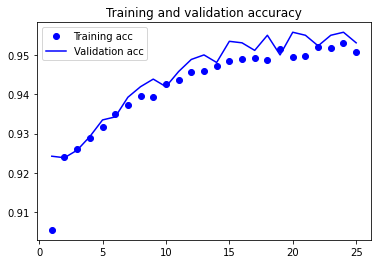

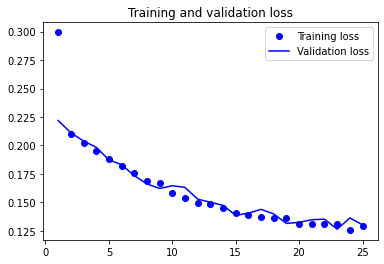

In [109]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [110]:
# Loading the automatically saved model
model_reloaded = load_model("./checkpoints/"+checkpoint_no + '/' + model_name)

# Saving the best model in the correct path and format
root_directory = os.getcwd()
checkpoint_dir = os.path.join(root_directory, checkpoint_no)
model_name_temp = os.path.join(checkpoint_dir, model_name + '.h5')
model_reloaded.save(model_name_temp)

# Deletion of the automatically created folder under Model Checkpoint File.
folder_name_temp = os.path.join(checkpoint_dir, model_name)
shutil.rmtree(folder_name_temp, ignore_errors=True)

In [111]:
best_model = load_model(model_name_temp)

In [112]:
test_loss, test_acc = best_model.evaluate(testX,
                                          testY,
                                          steps=n_test_steps)
print()
print('Test Accuracy:', test_acc)

131/131 [==============================] - 0s 2ms/step - loss: 0.1365 - accuracy: 0.9500

Test Accuracy: 0.949999988079071


In [121]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

In [123]:
y_pred = model.predict(testX)
y_pred[:5]

82/82 [==============================] - 1s 4ms/step


array([[9.9961925e-01, 3.8018523e-04, 2.3551479e-09, 5.7011960e-07],
       [9.9996185e-01, 2.9307423e-05, 8.8664510e-06, 1.0933741e-10],
       [1.0000000e+00, 4.3529923e-11, 2.7474676e-18, 3.8126365e-24],
       [9.9316251e-01, 5.9252740e-03, 8.1724027e-04, 9.4973504e-05],
       [9.9960572e-01, 3.4925187e-04, 1.7474120e-05, 2.7536069e-05]],
      dtype=float32)

In [114]:
testX[:5]

,PC1,PC2,PC3,PC4
16417,0.345885,-3.341976,-0.695332,0.288666
2854,-1.748944,-0.163722,0.856164,-0.751956
3341,-1.189987,-0.293923,-0.554588,0.855953
6613,2.621908,1.658528,-0.525549,-0.723336
14238,0.482081,-0.366635,-0.353075,0.429460


# Consumption Data with Known Variables

In [131]:
df = pd.read_csv('consumption_known_vars.csv')
df.drop("Unnamed: 0", axis=1, inplace=True)

print()
print('Shape of dataframe:')
print(str(df.shape))
print()
print('Head of dataframe:')
df.head()


Shape of dataframe:
(17460, 9)

Head of dataframe:


,AC(kW),Lighting(kW),Plug(kW),Temperature(C),Relative Humidity(%),Ambient Light(lux),isWeekend,Season,AnomalyType
0,0.01,0.0,0.02,28.23,64.42,0,1,1,0
1,0.01,0.0,0.05,28.30,64.52,0,1,1,0
2,0.01,0.0,0.02,28.13,65.33,0,1,1,0
3,0.01,0.0,0.06,28.11,65.52,0,1,1,0
4,0.01,0.0,0.07,28.12,65.84,0,1,1,0


In [132]:
x = df.drop('AnomalyType', axis=1)
y = df['AnomalyType']

In [135]:
numpy.set_printoptions(threshold=10)

encoder = OneHotEncoder()

encoded_Y = encoder.fit(y.values.reshape(-1,1))
encoded_Y = encoded_Y.transform(y.values.reshape(-1,1)).toarray()

encoded_Y

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]])

In [136]:
train_ratio = 0.70
validation_ratio = 0.15
test_ratio = 0.15

# Generate TrainX and TrainY
trainX, testX, trainY, testY = train_test_split(x, encoded_Y, test_size= 1 - train_ratio)
# Genearate ValX, TestX, ValY and TestY
valX, testX, valY, testY = train_test_split(testX, testY, test_size=test_ratio/(test_ratio + validation_ratio))

In [137]:
print(trainX.shape)
print(valX.shape)
print(testX.shape)

(12221, 8)
(2619, 8)
(2620, 8)


In [138]:
re_transformed_array_trainY = encoder.inverse_transform(trainY)

unique_elements, counts_elements = np.unique(re_transformed_array_trainY, return_counts=True)
unique_elements_and_counts_trainY = pd.DataFrame(np.asarray((unique_elements, counts_elements)).T)
unique_elements_and_counts_trainY.columns = ['unique_elements', 'count']

unique_elements_and_counts_trainY

,unique_elements,count
0,0,11064
1,1,329
2,2,318
3,3,510


In [139]:
re_transformed_array_valY = encoder.inverse_transform(valY)

unique_elements, counts_elements = np.unique(re_transformed_array_valY, return_counts=True)
unique_elements_and_counts_valY = pd.DataFrame(np.asarray((unique_elements, counts_elements)).T)
unique_elements_and_counts_valY.columns = ['unique_elements', 'count']

unique_elements_and_counts_valY

,unique_elements,count
0,0,2368
1,1,68
2,2,75
3,3,108


In [140]:
re_transformed_array_testY = encoder.inverse_transform(testY)

unique_elements, counts_elements = np.unique(re_transformed_array_testY, return_counts=True)
unique_elements_and_counts_testY = pd.DataFrame(np.asarray((unique_elements, counts_elements)).T)
unique_elements_and_counts_testY.columns = ['unique_elements', 'count']

unique_elements_and_counts_testY

,unique_elements,count
0,0,2374
1,1,63
2,2,78
3,3,105


In [141]:
checkpoint_no = 'ckpt_1_ANN'
model_name = 'Consumption_known_vars_ANN_2FC_F64_64_epoch_25'

In [142]:
input_shape = trainX.shape[1]

n_batch_size = 20

n_steps_per_epoch = int(trainX.shape[0] / n_batch_size)
n_validation_steps = int(valX.shape[0] / n_batch_size)
n_test_steps = int(testX.shape[0] / n_batch_size)

n_epochs = 25

num_classes = trainY.shape[1]

print('Input Shape: ' + str(input_shape))
print('Batch Size: ' + str(n_batch_size))
print()
print('Steps per Epoch: ' + str(n_steps_per_epoch))
print()
print('Validation Steps: ' + str(n_validation_steps))
print('Test Steps: ' + str(n_test_steps))
print()
print('Number of Epochs: ' + str(n_epochs))
print()
print('Number of Classes: ' + str(num_classes))

Input Shape: 8
Batch Size: 20

Steps per Epoch: 611

Validation Steps: 130
Test Steps: 131

Number of Epochs: 25

Number of Classes: 4


In [143]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(input_shape,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

In [144]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 64)                576       
                                                                 
 dense_31 (Dense)            (None, 64)                4160      
                                                                 
 dense_32 (Dense)            (None, 4)                 260       
                                                                 
Total params: 4,996
Trainable params: 4,996
Non-trainable params: 0
_________________________________________________________________


In [145]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [146]:
checkpoint_dir = './checkpoints/'+ checkpoint_no
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

In [147]:
keras_callbacks = [ModelCheckpoint(filepath = checkpoint_dir + '/' + model_name, 
                                   monitor='val_loss', save_best_only=True, mode='auto')]

In [148]:
history = model.fit(trainX,
                    trainY,
                    steps_per_epoch=n_steps_per_epoch,
                    epochs=n_epochs,
                    batch_size=n_batch_size,
                    validation_data=(valX, valY),
                    validation_steps=n_validation_steps,
                    callbacks=[keras_callbacks])

Epoch 1/25
611/611 [==============================] - 3s 4ms/step - loss: 0.5213 - accuracy: 0.8951 - val_loss: 0.3298 - val_accuracy: 0.9062
Epoch 2/25
611/611 [==============================] - 2s 3ms/step - loss: 0.3303 - accuracy: 0.9063 - val_loss: 0.2660 - val_accuracy: 0.9096
Epoch 3/25
611/611 [==============================] - 2s 3ms/step - loss: 0.2763 - accuracy: 0.9166 - val_loss: 0.4074 - val_accuracy: 0.9069
Epoch 4/25
611/611 [==============================] - 2s 3ms/step - loss: 0.2426 - accuracy: 0.9253 - val_loss: 0.2012 - val_accuracy: 0.9285
Epoch 5/25
611/611 [==============================] - 1s 2ms/step - loss: 0.2206 - accuracy: 0.9298 - val_loss: 0.2049 - val_accuracy: 0.9392
Epoch 6/25
611/611 [==============================] - 2s 3ms/step - loss: 0.1967 - accuracy: 0.9355 - val_loss: 0.1596 - val_accuracy: 0.9465
Epoch 7/25
611/611 [==============================] - 2s 3ms/step - loss: 0.1822 - accuracy: 0.9416 - val_loss: 0.1440 - val_accuracy: 0.9465
Epoch 

In [149]:
hist_df = pd.DataFrame(history.history)
hist_df['epoch'] = hist_df.index + 1
cols = list(hist_df.columns)
cols = [cols[-1]] + cols[:-1]
hist_df = hist_df[cols]
hist_df.to_csv("./checkpoints/" +checkpoint_no + '/' + 'history_df_' + model_name + '.csv')
hist_df.head()

,epoch,loss,accuracy,val_loss,val_accuracy
0,1,0.521315,0.895090,0.329791,0.906154
1,2,0.330282,0.906319,0.266017,0.909615
2,3,0.276257,0.916646,0.407421,0.906923
3,4,0.242620,0.925334,0.201194,0.928462
4,5,0.220566,0.929760,0.204885,0.939231


In [150]:
values_of_best_model = hist_df[hist_df.val_loss == hist_df.val_loss.min()]
values_of_best_model

,epoch,loss,accuracy,val_loss,val_accuracy
20,21,0.092478,0.962216,0.06739,0.97


In [151]:
class_assignment = dict(zip(y, encoded_Y))

df_temp = pd.DataFrame([class_assignment], columns=class_assignment.keys())
df_temp = df_temp.stack()
df_temp = pd.DataFrame(df_temp).reset_index().drop(['level_0'], axis=1)
df_temp.columns = ['Category', 'Allocated Number']

df_temp.to_csv("./checkpoints/"+checkpoint_no + '/' + 'class_assignment_df_' + model_name + '.csv')

print('Class assignment:')
class_assignment

Class assignment:


{0: array([1., 0., 0., 0.]),
 3: array([0., 0., 0., 1.]),
 1: array([0., 1., 0., 0.]),
 2: array([0., 0., 1., 0.])}

In [152]:
pk.dump(encoder, open("./checkpoints/" + checkpoint_no + '/' + 'encoder.pkl', 'wb'))

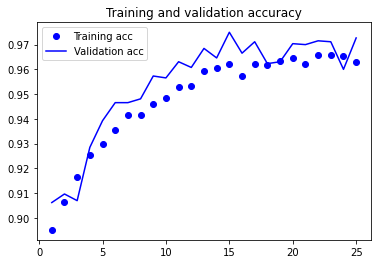

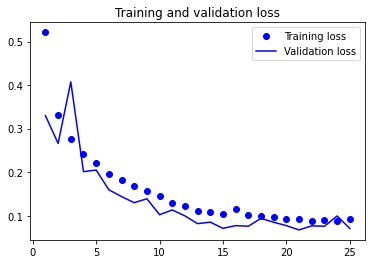

In [153]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [154]:
# Loading the automatically saved model
model_reloaded = load_model("./checkpoints/"+checkpoint_no + '/' + model_name)

# Saving the best model in the correct path and format
root_directory = os.getcwd()
checkpoint_dir = os.path.join(root_directory, checkpoint_no)
model_name_temp = os.path.join(checkpoint_dir, model_name + '.h5')
model_reloaded.save(model_name_temp)

# Deletion of the automatically created folder under Model Checkpoint File.
folder_name_temp = os.path.join(checkpoint_dir, model_name)
shutil.rmtree(folder_name_temp, ignore_errors=True)

In [155]:
best_model = load_model(model_name_temp)

In [156]:
test_loss, test_acc = best_model.evaluate(testX,
                                          testY,
                                          steps=n_test_steps)
print()
print('Test Accuracy:', test_acc)

131/131 [==============================] - 0s 1ms/step - loss: 0.0724 - accuracy: 0.9740

Test Accuracy: 0.9740458130836487


In [159]:
numpy.set_printoptions(threshold=sys.maxsize)
y_pred = model.predict(testX)
y_pred[:100]

82/82 [==============================] - 0s 1ms/step


array([[9.99997735e-01, 3.83758163e-08, 1.52353130e-09, 2.19330673e-06],
       [9.99998569e-01, 1.02845468e-06, 1.39614009e-09, 3.81638188e-07],
       [9.99997377e-01, 2.02097951e-07, 4.02287492e-09, 2.44273429e-06],
       [9.99995947e-01, 1.77576823e-07, 3.54839449e-06, 3.33166810e-07],
       [9.99997973e-01, 1.61695652e-06, 1.15247700e-09, 4.31471989e-07],
       [9.99994755e-01, 3.88216949e-06, 2.79290457e-09, 1.32156867e-06],
       [9.99849677e-01, 3.23568565e-05, 2.73748401e-06, 1.15151590e-04],
       [9.99999285e-01, 2.09195207e-07, 1.03305331e-09, 5.42787063e-07],
       [9.99999046e-01, 2.85547856e-07, 2.70226730e-09, 6.78106005e-07],
       [9.98132765e-01, 1.19115971e-03, 5.14226012e-05, 6.24662847e-04],
       [9.98463988e-01, 1.51609827e-03, 7.15117403e-06, 1.27839812e-05],
       [9.99998927e-01, 3.49724417e-07, 1.46179546e-09, 6.65832204e-07],
       [9.98611331e-01, 1.10425032e-03, 1.72196469e-05, 2.67136231e-04],
       [9.99974132e-01, 4.07346647e-07, 2.53814851e

In [161]:
testX[94:100]

,AC(kW),Lighting(kW),Plug(kW),Temperature(C),Relative Humidity(%),Ambient Light(lux),isWeekend,Season
11713,0.00,0.48,0.22,19.80,75.88,0,1,1
17335,0.00,0.00,0.05,25.13,60.31,0,1,2
4085,0.62,0.00,0.10,17.93,74.28,3,0,0
15048,0.01,0.81,0.05,25.83,56.45,1,1,2
16789,0.16,3.30,0.70,18.10,65.37,54,0,2
16286,0.01,0.00,0.05,22.89,43.98,2,0,2


# 3 Layers

Epoch 1/25
611/611 [==============================] - 4s 5ms/step - loss: 0.3829 - accuracy: 0.9055 - val_loss: 0.3274 - val_accuracy: 0.9050
Epoch 2/25
611/611 [==============================] - 4s 6ms/step - loss: 0.3138 - accuracy: 0.9096 - val_loss: 0.2607 - val_accuracy: 0.9162
Epoch 3/25
611/611 [==============================] - 3s 5ms/step - loss: 0.2617 - accuracy: 0.9183 - val_loss: 0.2466 - val_accuracy: 0.9192
Epoch 4/25
611/611 [==============================] - 3s 5ms/step - loss: 0.2260 - accuracy: 0.9271 - val_loss: 0.2018 - val_accuracy: 0.9358
Epoch 5/25
611/611 [==============================] - 3s 4ms/step - loss: 0.2050 - accuracy: 0.9319 - val_loss: 0.1950 - val_accuracy: 0.9312
Epoch 6/25
611/611 [==============================] - 3s 4ms/step - loss: 0.1858 - accuracy: 0.9386 - val_loss: 0.1511 - val_accuracy: 0.9492
Epoch 7/25
611/611 [==============================] - 2s 3ms/step - loss: 0.1637 - accuracy: 0.9423 - val_loss: 0.1712 - val_accuracy: 0.9431
Epoch 

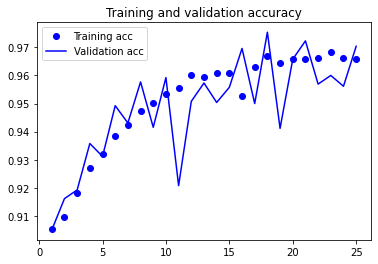

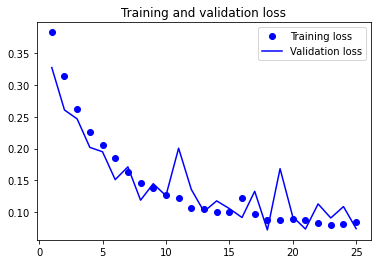

131/131 [==============================] - 0s 2ms/step - loss: 0.0650 - accuracy: 0.9718

Test Accuracy: 0.9717557430267334


In [9]:
import pandas as pd
import numpy as np
import os
import shutil
import pickle as pk
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from keras import models
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

df = pd.read_csv('consumption_known_vars.csv')
df.drop("Unnamed: 0", axis=1, inplace=True)

x = df.drop('AnomalyType', axis=1)
y = df['AnomalyType']

encoder = OneHotEncoder()

encoded_Y = encoder.fit(y.values.reshape(-1,1))
encoded_Y = encoded_Y.transform(y.values.reshape(-1,1)).toarray()

train_ratio = 0.70
validation_ratio = 0.15
test_ratio = 0.15

# Generate TrainX and TrainY
trainX, testX, trainY, testY = train_test_split(x, encoded_Y, test_size= 1 - train_ratio)
# Genearate ValX, TestX, ValY and TestY
valX, testX, valY, testY = train_test_split(testX, testY, test_size=test_ratio/(test_ratio + validation_ratio))

checkpoint_no = 'ckpt_1_ANN'
model_name = 'Consumption_ANN_2FC_F64_64_epoch_25_3layers'

input_shape = trainX.shape[1]

n_batch_size = 20

n_steps_per_epoch = int(trainX.shape[0] / n_batch_size)
n_validation_steps = int(valX.shape[0] / n_batch_size)
n_test_steps = int(testX.shape[0] / n_batch_size)

n_epochs = 25

num_classes = trainY.shape[1]

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(input_shape,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

checkpoint_dir = './checkpoints/'+ checkpoint_no
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
    
keras_callbacks = [ModelCheckpoint(filepath = checkpoint_dir + '/' + model_name, 
                                   monitor='val_loss', save_best_only=True, mode='auto')]

history = model.fit(trainX,
                    trainY,
                    steps_per_epoch=n_steps_per_epoch,
                    epochs=n_epochs,
                    batch_size=n_batch_size,
                    validation_data=(valX, valY),
                    validation_steps=n_validation_steps,
                    callbacks=[keras_callbacks])

hist_df = pd.DataFrame(history.history)
hist_df['epoch'] = hist_df.index + 1
cols = list(hist_df.columns)
cols = [cols[-1]] + cols[:-1]
hist_df = hist_df[cols]
hist_df.to_csv("./checkpoints/" +checkpoint_no + '/' + 'history_df_' + model_name + '.csv')

values_of_best_model = hist_df[hist_df.val_loss == hist_df.val_loss.min()]

class_assignment = dict(zip(y, encoded_Y))

df_temp = pd.DataFrame([class_assignment], columns=class_assignment.keys())
df_temp = df_temp.stack()
df_temp = pd.DataFrame(df_temp).reset_index().drop(['level_0'], axis=1)
df_temp.columns = ['Category', 'Allocated Number']

df_temp.to_csv("./checkpoints/"+checkpoint_no + '/' + 'class_assignment_df_' + model_name + '.csv')

pk.dump(encoder, open("./checkpoints/" + checkpoint_no + '/' + 'encoder.pkl', 'wb'))

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Loading the automatically saved model
model_reloaded = load_model("./checkpoints/"+checkpoint_no + '/' + model_name)

# Saving the best model in the correct path and format
root_directory = os.getcwd()
checkpoint_dir = os.path.join(root_directory, checkpoint_no)
model_name_temp = os.path.join(checkpoint_dir, model_name + '.h5')
model_reloaded.save(model_name_temp)

# Deletion of the automatically created folder under Model Checkpoint File.
folder_name_temp = os.path.join(checkpoint_dir, model_name)
shutil.rmtree(folder_name_temp, ignore_errors=True)

best_model = load_model(model_name_temp)

test_loss, test_acc = best_model.evaluate(testX,
                                          testY,
                                          steps=n_test_steps)
print()
print('Test Accuracy:', test_acc)

In [8]:
values_of_best_model

,epoch,loss,accuracy,val_loss,val_accuracy
24,25,0.109051,0.960823,0.118674,0.96


# 3 Layers, less nodes

Epoch 1/25
611/611 [==============================] - 4s 5ms/step - loss: 0.4794 - accuracy: 0.8943 - val_loss: 0.3696 - val_accuracy: 0.8981
Epoch 2/25
611/611 [==============================] - 4s 6ms/step - loss: 0.3325 - accuracy: 0.9078 - val_loss: 0.3369 - val_accuracy: 0.9062
Epoch 3/25
611/611 [==============================] - 3s 5ms/step - loss: 0.2675 - accuracy: 0.9183 - val_loss: 0.2323 - val_accuracy: 0.9265
Epoch 4/25
611/611 [==============================] - 2s 4ms/step - loss: 0.2271 - accuracy: 0.9272 - val_loss: 0.2571 - val_accuracy: 0.9173
Epoch 5/25
611/611 [==============================] - 4s 7ms/step - loss: 0.2008 - accuracy: 0.9319 - val_loss: 0.2030 - val_accuracy: 0.9354
Epoch 6/25
611/611 [==============================] - 4s 6ms/step - loss: 0.1800 - accuracy: 0.9393 - val_loss: 0.1586 - val_accuracy: 0.9373
Epoch 7/25
611/611 [==============================] - 4s 6ms/step - loss: 0.1596 - accuracy: 0.9426 - val_loss: 0.1548 - val_accuracy: 0.9412
Epoch 

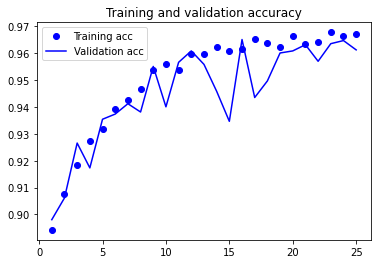

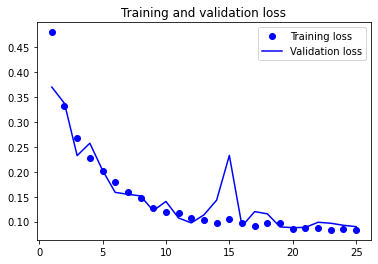

131/131 [==============================] - 0s 2ms/step - loss: 0.0649 - accuracy: 0.9744

Test Accuracy: 0.9744274616241455


In [11]:
import pandas as pd
import numpy as np
import os
import shutil
import pickle as pk
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from keras import models
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

df = pd.read_csv('consumption_known_vars.csv')
df.drop("Unnamed: 0", axis=1, inplace=True)

x = df.drop('AnomalyType', axis=1)
y = df['AnomalyType']

encoder = OneHotEncoder()

encoded_Y = encoder.fit(y.values.reshape(-1,1))
encoded_Y = encoded_Y.transform(y.values.reshape(-1,1)).toarray()

train_ratio = 0.70
validation_ratio = 0.15
test_ratio = 0.15

# Generate TrainX and TrainY
trainX, testX, trainY, testY = train_test_split(x, encoded_Y, test_size= 1 - train_ratio)
# Genearate ValX, TestX, ValY and TestY
valX, testX, valY, testY = train_test_split(testX, testY, test_size=test_ratio/(test_ratio + validation_ratio))

checkpoint_no = 'ckpt_1_ANN'
model_name = 'Consumption_ANN_2FC_F64_64_epoch_25_3layers'

input_shape = trainX.shape[1]

n_batch_size = 20

n_steps_per_epoch = int(trainX.shape[0] / n_batch_size)
n_validation_steps = int(valX.shape[0] / n_batch_size)
n_test_steps = int(testX.shape[0] / n_batch_size)

n_epochs = 25

num_classes = trainY.shape[1]

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(input_shape,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

checkpoint_dir = './checkpoints/'+ checkpoint_no
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
    
keras_callbacks = [ModelCheckpoint(filepath = checkpoint_dir + '/' + model_name, 
                                   monitor='val_loss', save_best_only=True, mode='auto')]

history = model.fit(trainX,
                    trainY,
                    steps_per_epoch=n_steps_per_epoch,
                    epochs=n_epochs,
                    batch_size=n_batch_size,
                    validation_data=(valX, valY),
                    validation_steps=n_validation_steps,
                    callbacks=[keras_callbacks])

hist_df = pd.DataFrame(history.history)
hist_df['epoch'] = hist_df.index + 1
cols = list(hist_df.columns)
cols = [cols[-1]] + cols[:-1]
hist_df = hist_df[cols]
hist_df.to_csv("./checkpoints/" +checkpoint_no + '/' + 'history_df_' + model_name + '.csv')

values_of_best_model = hist_df[hist_df.val_loss == hist_df.val_loss.min()]

class_assignment = dict(zip(y, encoded_Y))

df_temp = pd.DataFrame([class_assignment], columns=class_assignment.keys())
df_temp = df_temp.stack()
df_temp = pd.DataFrame(df_temp).reset_index().drop(['level_0'], axis=1)
df_temp.columns = ['Category', 'Allocated Number']

df_temp.to_csv("./checkpoints/"+checkpoint_no + '/' + 'class_assignment_df_' + model_name + '.csv')

pk.dump(encoder, open("./checkpoints/" + checkpoint_no + '/' + 'encoder.pkl', 'wb'))

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Loading the automatically saved model
model_reloaded = load_model("./checkpoints/"+checkpoint_no + '/' + model_name)

# Saving the best model in the correct path and format
root_directory = os.getcwd()
checkpoint_dir = os.path.join(root_directory, checkpoint_no)
model_name_temp = os.path.join(checkpoint_dir, model_name + '.h5')
model_reloaded.save(model_name_temp)

# Deletion of the automatically created folder under Model Checkpoint File.
folder_name_temp = os.path.join(checkpoint_dir, model_name)
shutil.rmtree(folder_name_temp, ignore_errors=True)

best_model = load_model(model_name_temp)

test_loss, test_acc = best_model.evaluate(testX,
                                          testY,
                                          steps=n_test_steps)
print()
print('Test Accuracy:', test_acc)

In [12]:
values_of_best_model

,epoch,loss,accuracy,val_loss,val_accuracy
19,20,0.084954,0.966396,0.087971,0.960769


# 1 Layer

Epoch 1/25
611/611 [==============================] - 4s 5ms/step - loss: 0.3878 - accuracy: 0.9020 - val_loss: 0.3928 - val_accuracy: 0.9065
Epoch 2/25
611/611 [==============================] - 4s 6ms/step - loss: 0.3095 - accuracy: 0.9085 - val_loss: 0.2470 - val_accuracy: 0.9215
Epoch 3/25
611/611 [==============================] - 4s 7ms/step - loss: 0.2516 - accuracy: 0.9194 - val_loss: 0.2241 - val_accuracy: 0.9219
Epoch 4/25
611/611 [==============================] - 2s 3ms/step - loss: 0.2288 - accuracy: 0.9266 - val_loss: 0.2254 - val_accuracy: 0.9273
Epoch 5/25
611/611 [==============================] - 3s 5ms/step - loss: 0.2224 - accuracy: 0.9268 - val_loss: 0.2208 - val_accuracy: 0.9265
Epoch 6/25
611/611 [==============================] - 3s 5ms/step - loss: 0.2237 - accuracy: 0.9257 - val_loss: 0.2025 - val_accuracy: 0.9300
Epoch 7/25
611/611 [==============================] - 2s 3ms/step - loss: 0.1975 - accuracy: 0.9327 - val_loss: 0.2420 - val_accuracy: 0.9288
Epoch 

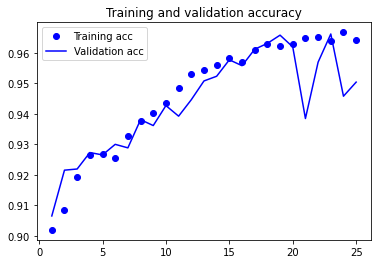

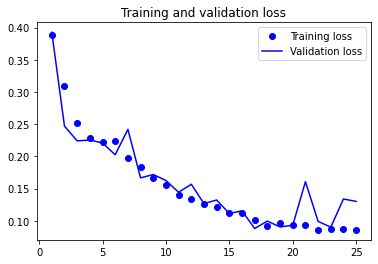

131/131 [==============================] - 0s 2ms/step - loss: 0.0840 - accuracy: 0.9649

Test Accuracy: 0.9648854732513428


In [169]:
import pandas as pd
import numpy as np
import os
import shutil
import pickle as pk
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from keras import models
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

df = pd.read_csv('consumption_known_vars.csv')
df.drop("Unnamed: 0", axis=1, inplace=True)

x = df.drop('AnomalyType', axis=1)
y = df['AnomalyType']

encoder = OneHotEncoder()

encoded_Y = encoder.fit(y.values.reshape(-1,1))
encoded_Y = encoded_Y.transform(y.values.reshape(-1,1)).toarray()

train_ratio = 0.70
validation_ratio = 0.15
test_ratio = 0.15

# Generate TrainX and TrainY
trainX, testX, trainY, testY = train_test_split(x, encoded_Y, test_size= 1 - train_ratio)
# Genearate ValX, TestX, ValY and TestY
valX, testX, valY, testY = train_test_split(testX, testY, test_size=test_ratio/(test_ratio + validation_ratio))

checkpoint_no = 'ckpt_1_ANN'
model_name = 'Consumption_ANN_2FC_F64_64_epoch_25_3layers'

input_shape = trainX.shape[1]

n_batch_size = 20

n_steps_per_epoch = int(trainX.shape[0] / n_batch_size)
n_validation_steps = int(valX.shape[0] / n_batch_size)
n_test_steps = int(testX.shape[0] / n_batch_size)

n_epochs = 25

num_classes = trainY.shape[1]

model = models.Sequential()
model.add(layers.Dense(120, activation='relu', input_shape=(input_shape,)))
model.add(layers.Dense(120, activation='relu'))
model.add(layers.Dense(120, activation='relu'))
model.add(layers.Dense(120, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

checkpoint_dir = './checkpoints/'+ checkpoint_no
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
    
keras_callbacks = [ModelCheckpoint(filepath = checkpoint_dir + '/' + model_name, 
                                   monitor='val_loss', save_best_only=True, mode='auto')]

history = model.fit(trainX,
                    trainY,
                    steps_per_epoch=n_steps_per_epoch,
                    epochs=n_epochs,
                    batch_size=n_batch_size,
                    validation_data=(valX, valY),
                    validation_steps=n_validation_steps,
                    callbacks=[keras_callbacks])

hist_df = pd.DataFrame(history.history)
hist_df['epoch'] = hist_df.index + 1
cols = list(hist_df.columns)
cols = [cols[-1]] + cols[:-1]
hist_df = hist_df[cols]
hist_df.to_csv("./checkpoints/" +checkpoint_no + '/' + 'history_df_' + model_name + '.csv')

values_of_best_model = hist_df[hist_df.val_loss == hist_df.val_loss.min()]

class_assignment = dict(zip(y, encoded_Y))

df_temp = pd.DataFrame([class_assignment], columns=class_assignment.keys())
df_temp = df_temp.stack()
df_temp = pd.DataFrame(df_temp).reset_index().drop(['level_0'], axis=1)
df_temp.columns = ['Category', 'Allocated Number']

df_temp.to_csv("./checkpoints/"+checkpoint_no + '/' + 'class_assignment_df_' + model_name + '.csv')

pk.dump(encoder, open("./checkpoints/" + checkpoint_no + '/' + 'encoder.pkl', 'wb'))

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Loading the automatically saved model
model_reloaded = load_model("./checkpoints/"+checkpoint_no + '/' + model_name)

# Saving the best model in the correct path and format
root_directory = os.getcwd()
checkpoint_dir = os.path.join(root_directory, checkpoint_no)
model_name_temp = os.path.join(checkpoint_dir, model_name + '.h5')
model_reloaded.save(model_name_temp)

# Deletion of the automatically created folder under Model Checkpoint File.
folder_name_temp = os.path.join(checkpoint_dir, model_name)
shutil.rmtree(folder_name_temp, ignore_errors=True)

best_model = load_model(model_name_temp)

test_loss, test_acc = best_model.evaluate(testX,
                                          testY,
                                          steps=n_test_steps)
print()
print('Test Accuracy:', test_acc)

Epoch 1/25
611/611 [==============================] - 6s 7ms/step - loss: 0.2705 - accuracy: 0.9157 - val_loss: 0.2236 - val_accuracy: 0.9181
Epoch 2/25
611/611 [==============================] - 3s 5ms/step - loss: 0.2068 - accuracy: 0.9243 - val_loss: 0.2289 - val_accuracy: 0.9181
Epoch 3/25
611/611 [==============================] - 5s 7ms/step - loss: 0.1973 - accuracy: 0.9275 - val_loss: 0.2088 - val_accuracy: 0.9231
Epoch 4/25
611/611 [==============================] - 6s 9ms/step - loss: 0.1900 - accuracy: 0.9320 - val_loss: 0.2085 - val_accuracy: 0.9254
Epoch 5/25
611/611 [==============================] - 3s 5ms/step - loss: 0.1801 - accuracy: 0.9334 - val_loss: 0.2261 - val_accuracy: 0.9169
Epoch 6/25
611/611 [==============================] - 4s 6ms/step - loss: 0.1660 - accuracy: 0.9390 - val_loss: 0.1778 - val_accuracy: 0.9350
Epoch 7/25
611/611 [==============================] - 5s 8ms/step - loss: 0.1536 - accuracy: 0.9427 - val_loss: 0.1724 - val_accuracy: 0.9335
Epoch 

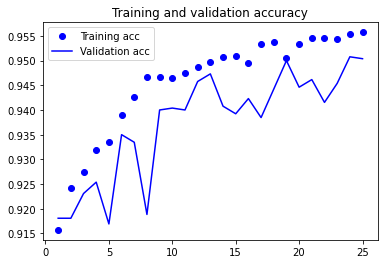

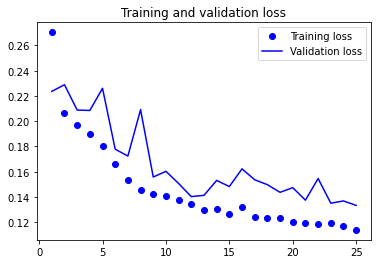

131/131 [==============================] - 1s 2ms/step - loss: 0.1207 - accuracy: 0.9561

Test Accuracy: 0.9561068415641785


In [77]:
import pandas as pd
import numpy as np
import os
import shutil
import pickle as pk
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from keras import models
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

df = pd.read_csv('consumption.csv').dropna()
df.drop("Unnamed: 0", axis=1, inplace=True)

x = df.drop('AnomalyType', axis=1)
y = df['AnomalyType']

encoder = OneHotEncoder()

encoded_Y = encoder.fit(y.values.reshape(-1,1))
encoded_Y = encoded_Y.transform(y.values.reshape(-1,1)).toarray()

train_ratio = 0.70
validation_ratio = 0.15
test_ratio = 0.15

# Generate TrainX and TrainY
trainX, testX, trainY, testY = train_test_split(x, encoded_Y, test_size= 1 - train_ratio)
# Genearate ValX, TestX, ValY and TestY
valX, testX, valY, testY = train_test_split(testX, testY, test_size=test_ratio/(test_ratio + validation_ratio))

checkpoint_no = 'ckpt_1_ANN'
model_name = 'Consumption_ANN_2FC_F64_64_epoch_25_3layers'

input_shape = trainX.shape[1]

n_batch_size = 20

n_steps_per_epoch = int(trainX.shape[0] / n_batch_size)
n_validation_steps = int(valX.shape[0] / n_batch_size)
n_test_steps = int(testX.shape[0] / n_batch_size)

n_epochs = 25

num_classes = trainY.shape[1]

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(input_shape,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

checkpoint_dir = './checkpoints/'+ checkpoint_no
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
    
keras_callbacks = [ModelCheckpoint(filepath = checkpoint_dir + '/' + model_name, 
                                   monitor='val_loss', save_best_only=True, mode='auto')]

history = model.fit(trainX,
                    trainY,
                    steps_per_epoch=n_steps_per_epoch,
                    epochs=n_epochs,
                    batch_size=n_batch_size,
                    validation_data=(valX, valY),
                    validation_steps=n_validation_steps,
                    callbacks=[keras_callbacks])

hist_df = pd.DataFrame(history.history)
hist_df['epoch'] = hist_df.index + 1
cols = list(hist_df.columns)
cols = [cols[-1]] + cols[:-1]
hist_df = hist_df[cols]
hist_df.to_csv("./checkpoints/" +checkpoint_no + '/' + 'history_df_' + model_name + '.csv')

values_of_best_model = hist_df[hist_df.val_loss == hist_df.val_loss.min()]

class_assignment = dict(zip(y, encoded_Y))

df_temp = pd.DataFrame([class_assignment], columns=class_assignment.keys())
df_temp = df_temp.stack()
df_temp = pd.DataFrame(df_temp).reset_index().drop(['level_0'], axis=1)
df_temp.columns = ['Category', 'Allocated Number']

df_temp.to_csv("./checkpoints/"+checkpoint_no + '/' + 'class_assignment_df_' + model_name + '.csv')

pk.dump(encoder, open("./checkpoints/" + checkpoint_no + '/' + 'encoder.pkl', 'wb'))

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Loading the automatically saved model
model_reloaded = load_model("./checkpoints/"+checkpoint_no + '/' + model_name)

# Saving the best model in the correct path and format
root_directory = os.getcwd()
checkpoint_dir = os.path.join(root_directory, checkpoint_no)
model_name_temp = os.path.join(checkpoint_dir, model_name + '.h5')
model_reloaded.save(model_name_temp)

# Deletion of the automatically created folder under Model Checkpoint File.
folder_name_temp = os.path.join(checkpoint_dir, model_name)
shutil.rmtree(folder_name_temp, ignore_errors=True)

best_model = load_model(model_name_temp)

test_loss, test_acc = best_model.evaluate(testX,
                                          testY,
                                          steps=n_test_steps)
print()
print('Test Accuracy:', test_acc)

In [68]:
values_of_best_model

,epoch,loss,accuracy,val_loss,val_accuracy
19,20,0.122111,0.952873,0.132037,0.952308


In [55]:
y_pred = best_model.predict(testX)

82/82 [==============================] - 0s 1ms/step


In [56]:
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [57]:
y_pred = (y_pred > 0.5) 

In [58]:
testY = (testY > 0.5)

In [59]:
print('Recall: %.3f' % recall_score(testY, y_pred, pos_label='positive',
                                           average='micro'))
print('F1 Score: %.3f' % f1_score(testY, y_pred, pos_label='positive',
                                           average='micro'))

Recall: 0.968
F1 Score: 0.970


C:\Users\aleks\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1298: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that pos_label (set to %r) is ignored when "
C:\Users\aleks\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1298: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that pos_label (set to %r) is ignored when "


In [38]:
testY[0]

array([ True, False, False, False])

In [36]:
y_pred[0]

array([ True, False, False, False])

Logistic regression

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import model_selection
from sklearn import linear_model
from sklearn import metrics

df = pd.read_csv('consumption.csv').dropna()
df.drop("Unnamed: 0", axis=1, inplace=True)

x = df.drop('AnomalyType', axis=1)
y = df['AnomalyType']

X_train, X_test, y_train, y_test = model_selection.train_test_split(x, y, test_size= 0.3, random_state = 1)

print('X_train dimension= ', X_train.shape)
print('X_test dimension= ', X_test.shape)
print('y_train dimension= ', y_train.shape)
print('y_train dimension= ', y_test.shape)

lm = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear')
lm.fit(X_train, y_train)

lm.score(X_test, y_test)

print(metrics.classification_report(y_test, lm.predict(X_test)))

X_train dimension=  (12222, 4)
X_test dimension=  (5238, 4)
y_train dimension=  (12222,)
y_train dimension=  (5238,)
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      4720
           1       0.50      0.17      0.25       149
           2       0.44      0.08      0.13       151
           3       0.27      0.15      0.19       218

    accuracy                           0.91      5238
   macro avg       0.54      0.35      0.38      5238
weighted avg       0.88      0.91      0.88      5238



In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import model_selection
from sklearn import linear_model
from sklearn import metrics

df = pd.read_csv('consumption_known_vars.csv')
df.drop("Unnamed: 0", axis=1, inplace=True)

x = df.drop('AnomalyType', axis=1)
y = df['AnomalyType']

X_train, X_test, y_train, y_test = model_selection.train_test_split(x, y, test_size= 0.3, random_state = 1)

print('X_train dimension= ', X_train.shape)
print('X_test dimension= ', X_test.shape)
print('y_train dimension= ', y_train.shape)
print('y_train dimension= ', y_test.shape)

lm = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear')
lm.fit(X_train, y_train)

lm.score(X_test, y_test)

print(metrics.classification_report(y_test, lm.predict(X_test)))

X_train dimension=  (12222, 8)
X_test dimension=  (5238, 8)
y_train dimension=  (12222,)
y_train dimension=  (5238,)
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      4720
           1       1.00      0.54      0.70       149
           2       0.78      0.35      0.48       151
           3       0.87      0.69      0.77       218

    accuracy                           0.95      5238
   macro avg       0.90      0.65      0.73      5238
weighted avg       0.95      0.95      0.95      5238

